# Multiclass Classification of Fatal Car Crashes
Authors:  Ned Kost, Ulises Gomez
Date:  August 25th, 2023

## Goal
Predict the contributing factor for a fatal car crash.  The contributing factor will fall into 3 categories: 
- drunk_driver_involved
- speeding_driver_involved
- other

## TODO
- Load Data into dataframe and clean it
- Identify features to use for the classifier model
- Find a classifier that will do multiclass and probabilty as output.  Preferrably with explainability
- Dockerize the output

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



## Load and Clean Data

In [71]:
#Load data from Dataframe
df = pd.read_csv('data/fars_train.csv', quoting=1, delimiter=',')
df.head()

,u_id,fatals,a_ct,a_ped_f,a_pedal_f,a_roll,a_hr,a_polpur,month,day,...,owner,deaths,numoccs,impact1,deformed,ve_forms,ve_total,weather,lgt_cond,driver_factor
0,32083,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,10,2,...,Driver (in this crash) Was Registered Owner,1,1.0,Clockpoint 12,Disabling damage,1,1,Clear,Dark - not lighted,other
1,55073,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,6,21,...,Driver (in this crash) Not Registered Owner (o...,1,1.0,Clockpoint 1,Disabling damage,1,1,Clear,Daylight,speeding_driver_involved
2,7458,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,7,14,...,Driver (in this crash) Was Registered Owner,0,1.0,Clockpoint 12,NaN,1,1,Clear,Daylight,other
3,5685,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,9,15,...,Driver (in this crash) Not Registered Owner (o...,0,1.0,Clockpoint 12,Functional damage,1,1,Clear,Dark - not lighted,other
4,9245,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,9,28,...,Driver (in this crash) Was Registered Owner,1,1.0,Clockpoint 9,Disabling damage,1,1,Clear,Dark - not lighted,drunk_driver_involved


In [72]:
def binary_cat(row_value, zero_value):
    if(row_value == zero_value):
        return 0
    else:
        return 1


In [90]:
#Clean up Categorical Data
features = ['fatals', 'age', 'permvit', 'deaths']

cleaned_df = df[features]

#Create columns for Binary Features
cleaned_df['is_ped_fatality'] = df['a_ped_f'].apply(lambda x: binary_cat(x, 'Other Crash'))
cleaned_df['is_weekend'] = df['a_dow_type'].apply(lambda x: binary_cat(x, 'Weekday'))
cleaned_df['is_night'] = df['a_tod_type'].apply(lambda x: binary_cat(x, 'Daytime'))
cleaned_df['is_urban'] = df['a_ru'].apply(lambda x: binary_cat(x, 'Rural'))
cleaned_df['is_inter'] = df['a_inter'].apply(lambda x: binary_cat(x, 'Non-Interstate'))
cleaned_df['is_intsec'] = df['a_intsec'].apply(lambda x: binary_cat(x, 'Non-Intersection'))
cleaned_df['on_roadway'] = df['a_relrd'].apply(lambda x: 1 if x.startswith('On') else 0)
cleaned_df['off_roadway'] = df['a_relrd'].apply(lambda x: 1 if x.startswith('Off') else 0)
cleaned_df['is_junc'] = df['a_junc'].apply(lambda x: 1 if str(x).startswith('Junct') else 0)
cleaned_df['not_junc'] = df['a_junc'].apply(lambda x: 1 if str(x).startswith('Non') else 0)


#Create columns for non-Ordinal Features
label_encoder = LabelEncoder()     #Create Label Encoder
cleaned_df['body_type'] = label_encoder.fit_transform(df['a_body'])
cleaned_df['owner_reg'] = label_encoder.fit_transform(df['owner'])
cleaned_df['impact_loc'] = label_encoder.fit_transform(df['impact1'])
cleaned_df['weather_cond'] = label_encoder.fit_transform(df['weather'])
cleaned_df['light_cond'] = label_encoder.fit_transform(df['lgt_cond'])


#Create column for Ordinal Features (treating as non-ordinal FOR NOW)
cleaned_df['road_type'] = label_encoder.fit_transform(df['a_roadfc'])
cleaned_df['deform_type'] = label_encoder.fit_transform(df['deformed'])


cleaned_df.head()

C:\Users\nedko\AppData\Local\Temp\ipykernel_32452\2227903271.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['is_ped_fatality'] = df['a_ped_f'].apply(lambda x: binary_cat(x, 'Other Crash'))
C:\Users\nedko\AppData\Local\Temp\ipykernel_32452\2227903271.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['is_weekend'] = df['a_dow_type'].apply(lambda x: binary_cat(x, 'Weekday'))
C:\Users\nedko\AppData\Local\Temp\ipykernel_32452\2227903271.py:9: SettingWithCopyWarning: 
A value is tryin

,fatals,age,permvit,deaths,is_ped_fatality,is_weekend,is_night,is_urban,is_inter,is_intsec,...,off_roadway,is_junc,not_junc,body_type,owner_reg,impact_loc,weather_cond,light_cond,road_type,deform_type
0,1,62,1,1,0,0,1,0,0,0,...,1,0,1,2,1,4,2,1,4,0
1,1,40,1,1,0,0,0,0,0,0,...,1,0,1,7,0,1,2,4,3,0
2,1,26,1,0,0,0,1,0,0,0,...,0,0,1,2,1,4,2,4,2,4
3,1,64,1,0,0,0,1,1,0,1,...,0,1,0,0,0,4,2,1,5,1
4,1,45,1,1,0,0,1,0,0,0,...,1,0,1,0,1,12,2,1,2,0


# Build Train and Test dataset

In [123]:
X = cleaned_df
y = df['driver_factor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=125)

In [124]:
model = MultinomialNB()
model.fit(X,y)

MultinomialNB()

In [125]:
predict = model.predict(X_test)


drunk_driver_involved speeding_driver_involved


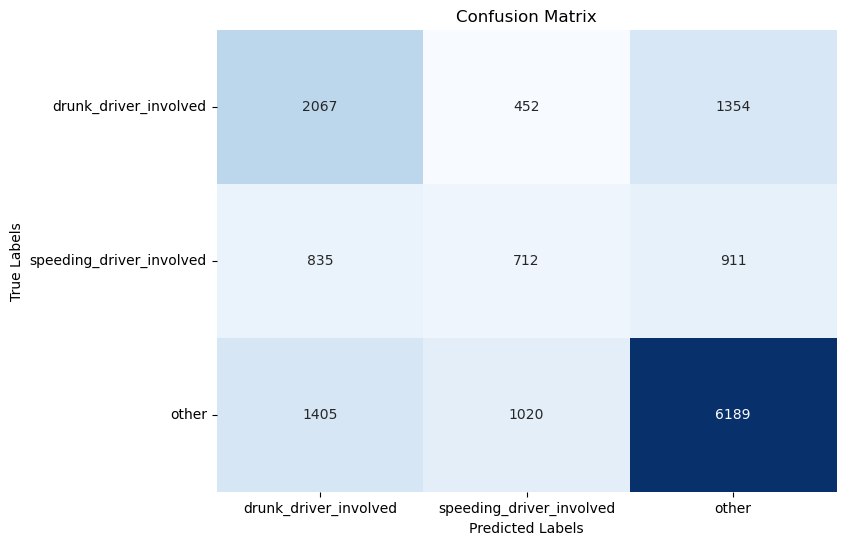

In [134]:

cat_lbl = ['drunk_driver_involved', 'speeding_driver_involved','other']
cm = confusion_matrix(y_test, predict, labels = cat_lbl )


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=cat_lbl,  yticklabels=cat_lbl)
plt.xlabel("Predicted Labels")

plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [142]:
f1_score(y_test, predict, average='macro', labels=cat_lbl)

0.5124533595886245